<div align="right">Naoaki ONO, Shigehiko KANAYA <br/>
NAIST DSC</div>

[Open in Google Colaboratory](https://colab.research.google.com/github/naono-git/colaboratory/blob/master/note_03_hello_NN.ipynb)

# はじめてのNeural Networks

ニューラルネットワークの原理を理解するために簡単なデータを学習させてみましょう。

まずは下準備として計算用のライブラリをインポートします。

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


乱数を使って学習用のデータを生成します。

ここでは1次元の説明変数`x`の値から1次元の目標変数`y`の値を予測することを課題とします。

このように与えられた説明変数から求めた予測値が目標の値に近づくようにパラメータを最適化するモデルを一般に回帰モデルと呼んだりします。

説明変数、目的変数はもっと高次元の場合も多々あります。

`y`がどんな関数かは後ほど。

In [0]:
nx = 1000
xx = np.sort(np.random.uniform(size=nx)*np.pi*2)
yy = np.sin(xx)+0.5*np.cos(4*xx)+np.random.normal(0, 0.3, size=nx)
y0 = np.sin(xx)+0.5*np.cos(4*xx)

次にモデルとなるニューラルネットワークを構築します。

内部ではTensorFlowが使われていますが、各ステップごとに関数を細かく書かなくてもモデルを構築できるツール（このようなライブラリを"包み隠すモノ"を意味する"ラッパー"と呼んだりします）として開発された"Keras"ライブラリを利用することにします。

In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Dropout, Activation

Using TensorFlow backend.


## ネットワークの構築

とりあえず最も単純なタイプのニューラルネットを構築します。
ネットワークの各層のノード数などを指定して、モデルに追加していくことでネットワークが定義できるようになっています。

In [0]:
model1 = Sequential()
model1.add(Dense(7, input_shape=(1,), activation='tanh'))
model1.add(Dense(7, activation='tanh'))
model1.add(Dense(7, activation='tanh'))
model1.add(Dense(7, activation='tanh'))
model1.add(Dense(7, activation='tanh'))
model1.add(Dense(1, activation='linear'))
           
model1.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 246
Trainable params: 246
Non-trainable params: 0
______

たかが1次元の関数に246個ものパラメータは若干オーバースペックかもしれませんが、データのサンプル数が十分多いのでなんとかなるでしょうか。


入力は`x`の値だけなので一次元、最終的な出力も一次元で、各層に7ノードを配置した中間層としてを5層挟んだものをとりあえず構築してみました。

`Dense`というのは各ノードが全て結合された全結合ネットワークと呼ばれるものです。

入力されたベクトルに結合の重みを掛けて足し合わせ（切片の項を足し）た活性化値に活性化関数を適用したものが各ノードの出力値になります。数式にすると次のようになります。$W$が重み係数、$b$はバイアス項と呼ばれるものになります。


$$
v_{1,i} (x) = \tanh \left( W_{1,i} x + b_{1,i} \right)\\
v_{2,i}(\mathbf{v}_1) =  \tanh\left( \sum_{j=1}^7 W_{2,ij} v_{1,j} +b_{2,i} \right)\\
\vdots \textrm{以下繰り返し}
$$

ちなみにこの"活性化関数"を適用しないと、多層パーセプトロンと呼ばれる単なる線型結合のモデルになってしまい、理論上あまり複雑な学習をすることができないことがわかっています。

そこで何らかの非線形な活性化関数を適用するのがニューラルネットワークの要点になっています。が、実のところどんな関数にすれば最適か、は現在でもいささか議論が分かれています。

かつては神経細胞の働きを模したシグモイド関数が主に用いられました。
今回は目的変数に負の値も含まれるので、シグモイドとよく似た関数である$\tanh()$を使っています。最近ではランプ関数とも呼ばれるRectified Linear Unit (ReLU)が用いられることが多くなっています。


最後に5層目のノードの出力に重みを掛けて足し合わせた1ノードの出力を予想される`y`の値としています。


## 学習アルゴリズム
回帰モデルでは各入力の`x`に対して出力された`y`の予想値$\hat{y}$と、教師データの$y$の値との誤差が最小になるように各層のネットワークの重み係数を最適化していきます。通常は二つの値の差を二乗して平均をとったものを用います。


誤差を小さくするように各$W_{l,ij}$の微分を計算し、少しずつ重みを修正していきます。修正のステップ数が少なくなるようにいろいろなアルゴリズムが提案されており、ここではAdaGradと呼ばれるアルゴリズムを用いています。詳細は長くなるのでここでは割愛させていただきます。

In [0]:
model1.compile(loss='mean_squared_error', optimizer='adagrad',
               metrics=['accuracy'])

### 走らせてみよう
まず`verbose=1, epochs=10`として
10ステップ(epoch)ほど試し、残差(`loss`)の値が減っていくかどうか試してみてください（`verbose`は途中経過を表示するかどうかのオプションです）。


順調に減っているようなら
`verbose=0, epochs=300`ぐらいにして数百ステップ学習させてみましょう。

...2、3分かかるかもしれません。


In [0]:
history1 = model1.fit(x=xx, y=yy, verbose=0, epochs=10,
                      shuffle=True)
model1.evaluate(x=xx,y=yy)


Instructions for updating:
Use tf.cast instead.
1000/1000 [==============================] - 0s 47us/step


[0.30985873341560366, 0.0]

残差がそこそこ下がったでしょうか。

今回は教師データの生成の際にノイズを加えているので残差はそれほど小さくなりません。

必要ならepochの値を適宜変えて上のセルを再度実行すれば、追加で学習を続けることも可能です。満足がいくまで学習させてみてください。

## Prediction

学習結果を確認してみましょう。

`predict()`関数で与えられた`x`に対する予測値を生成できるので、教師データと比べてみます。

In [0]:
yy_pred = model1.predict(xx)

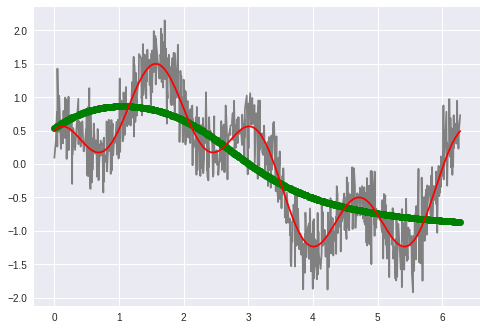

In [0]:
plt.plot(xx,yy, color="grey")
plt.plot(xx,yy_pred,"o",color="green")
plt.plot(xx,y0, color="red")

灰色が教師データ、赤のラインがノイズを除いた理論値、
緑がモデルによる予測値です。

あまりフィットできていない部分もありますがまあだいたいの傾向はつかめているでしょうか。


## ネットワークの解体

ネットワークの構築にKerasツールを使ったのでTensorFlowで直接計算を描くよりも手軽な分、あまり細部を確認していませんでしたが、構築された`model1`オブジェクトから学習の結果や途中の計算の詳細を取り出すことも可能です。


例えば`model1.layers`は入力層から出力層までの各層がオブジェクトとして含まれたリストになっています。

In [0]:
model1.layers

自動で取得されるアドレスしか表示されないのでどれがどの層か若干わかりにくいですが、
今回は上から順に各層に対応していると考えてOKです。

（必要ならばネットワークの定義の時に各層にわかりやすい名前やIDをつけることは可能です）


### 重みパラメータの読み出し
それぞれの層のオブジェクトから重みの値などをとりだすことができます。

ただし、Define-and-runモデルなので、重みの値を具体的に取り出すときは`sess.run()`で評価する必要があります。

例えば先ほどの式にあった、2つめの中間層の重み係数$W_{2}$の値を見てみましょう。

入力層が1つ目（`model1.layers[0]`）なので、2つ目の中間層は`model1.layers[1]`になります。

入力層7ノードから中間層7ノードへの全結合なので`weights`の次元は(7x7)の行列になっています。

値は...まあ数字だけ見てもすぐに解釈はできないので一部だけちょっと表示してみます。

（値を見ても計算の中身は一見しただけではわかりませんが、例えば「重みが全部0」のようなおかしな結果でないか確認することは大事です）

In [0]:
import keras.backend as K
sess = K.get_session()

tmp = model1.layers[1]

print(tmp.weights[0].shape)

sess.run(tmp.weights[0])[0:4,0:4]

(7, 7)


array([[ 0.05602787, -0.5559305 , -0.16826575, -0.4138951 ],
       [ 0.58608586,  0.33701178, -0.34072545,  0.21795325],
       [-0.2382877 ,  0.24068098,  0.24646904, -0.07289904],
       [ 0.45557734, -0.19220771, -0.7463935 , -0.6984948 ]],
      dtype=float32)

各層のノードがどんな出力を出しているか、具体的にみてみましょう。

出力先のTensorオブジェクトは以下のように取り出せます。

In [0]:
tmp = model1.layers[1]
print(tmp)
print(tmp.get_output_at(0))

Tensor("dense_2/Tanh:0", shape=(?, 7), dtype=float32)


In [0]:
l0 = model1.layers[0].get_output_at(0)
l1 = model1.layers[1].get_output_at(0)
l2 = model1.layers[2].get_output_at(0)
l3 = model1.layers[3].get_output_at(0)
l4 = model1.layers[4].get_output_at(0)
l5 = model1.layers[5].get_output_at(0)

先ほどの`weight`は計算済みの値なので引数なしでも値を評価することができましたが、各ノードの出力の値は入力したデータによるので評価の際に引数を与える必要があります。

引数の入力データを`run()`関数に与えるために`feed_dict`を作ります。

In [0]:
input1 = model1.layers[0].get_input_at(0)
i1 = xx.reshape((nx,1))
fd1 = {input1: i1}

この`fd1`を入力とした時の個々の出力先を具体的に計算します。

In [0]:
out0, out1, out2, out3, out4, out5 = sess.run((l0,l1,l2,l3,l4,l5),feed_dict=fd1)

各層の出力がどのようになっているか、プロットしてみましょう。

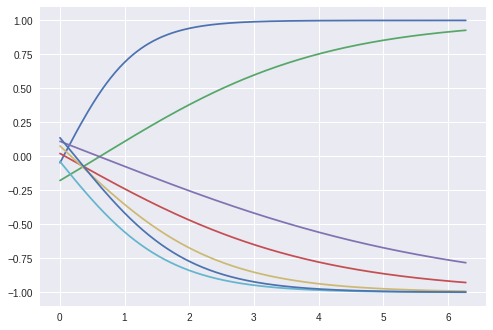

In [0]:
dumb = plt.plot(xx,out0)

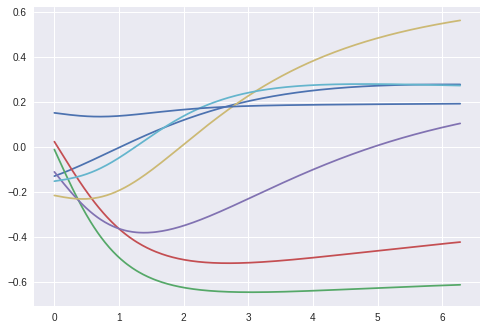

In [0]:
dumb = plt.plot(xx,out1)

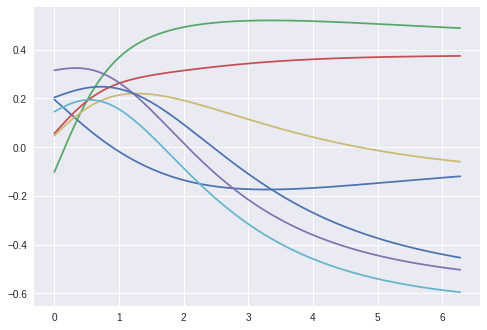

In [0]:
dumb = plt.plot(xx,out2)

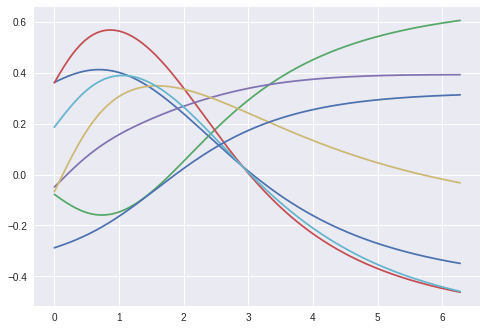

In [0]:
dumb = plt.plot(xx,out3)

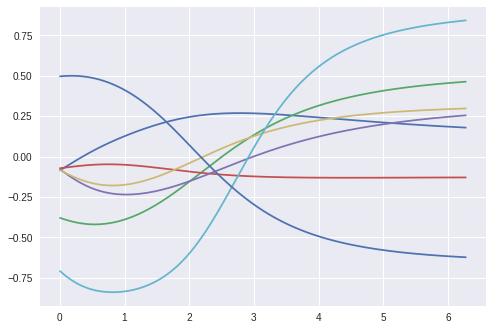

In [0]:
dumb = plt.plot(xx,out4)

この最終層の出力に、各ノードの重みを掛けて足し合わせたのが目的変数の予測値になります。

重みの係数は先ほどと同様、以下のように確認できます。

In [0]:
sess.run(model1.layers[5].weights[0])

array([[ 0.24690998],
       [-0.3218135 ],
       [ 0.02039549],
       [-0.6329514 ],
       [-0.39789292],
       [-0.82092303],
       [-0.38933086]], dtype=float32)

`out4`の値にこれを掛けて足し合わせたのが`out5`の値で、先ほど使った`prediction`の値と同じものになります。

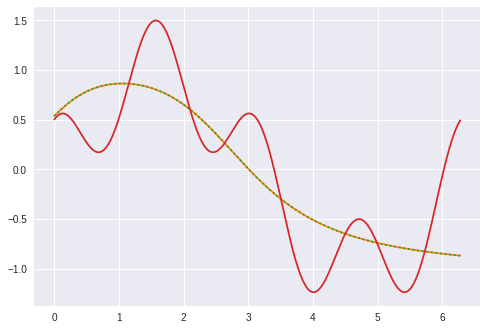

In [0]:
cmap = plt.get_cmap("tab10") 
tmp = plt.plot(xx, yy_pred, color=cmap(1))
tmp = plt.plot(xx, out5, color=cmap(2), linestyle=':')
tmp = plt.plot(xx, y0, color=cmap(3))

## ハイパーパラメータ

今回は各7ノードの中間層を5層使ったネットワークを使って学習していますが、もっと多い、あるいは少ない層のネットワークで学習できるのかどうか、各層のノード数をいくつにするのがいいのか、活性化関数として`tanh`以外の関数を使ったらどうなるのか、学習のアルゴリズムをAdaGrad以外にしたら収束は早くなるのか、遅くなるのか...etc. etc.、より精度のいい、また効率の良い学習を目指そうとすると調べなければならないポイントは多岐に渡ります。

残りの時間、ノード数や層の数をいろいろ変えて、学習結果を比較してみてください。

正直なところ、私もこの課題の場合にどのようなネットワークなら最も精度が良くなるのか、わかりません。理論値をぴったり予測できるモデルができたら教えていただけると幸いです。




残念ながら現状ではこれらのさまざまな条件ーーニューラルネットの重みパラメータの学習方法を決定するパラメータなので、「ハイパーパラメータ」と呼ばれますーーを最適化する一般的な方法は知られていません。

基本的には勘で決めた値から始めてテストしながら細かく試行錯誤を繰り返す形になります。

もう一つは「グリッドサーチ」と呼ばれるアプローチになりますが、要は適当な範囲で網羅的にハイパーパラメータの組み合わせを生成して総当たり的に学習を行い、一番うまくいったものを選ぶ、という力まかせな手法のことを指します。

## そして深層へ

今回は5層のニューラルネットを例に出しましたが、この層の数が増えたものがいわゆる深層学習になります。何層以上なら"ディープ"かという決まりはありませんが、たいだい10層以上の印象でしょうか。

ニュースに出てくるような深層学習のモデルはとても高度な学習をしているようですが、本質的な原理としてはここで行なった計算とあまり変わりありませんーーこのような計算を、何十層ものレイヤーと何十万のパラメーターを使い、膨大なデータを使って最適化しているものです。
